## Training VAE Autoencoder with ignition events (2)

**Status:** PUBLIC Distribution <br>
**File Name:** 03_Autoencoder_training_ignition_events(2).ipynb

**Author:** Jaume Manero / Darshana Upadhyay / Richard Purcell<br> 
**Date created:** 2023/06/19<br>
**Last modified:** 2023/06/19<br>
**Description:** Autoencoders for Forest Fire prediction

We train an autoencoder with a file with Ignition events. This is the first notebook. In this notebook we train the autoencoder to recognize ignition events. There is a map visualization of ignition events in BC

This version uses StandardScaling

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras.optimizers.legacy import SGD,Adam,RMSprop
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Hyperparameters



In [3]:
path_ignition = './Data/ignition_rows.csv'
path_non_ignition = './Data/non_ignition_rows.csv'
ignition_df = pd.read_csv(path_ignition)  
non_ignition_df = pd.read_csv(path_non_ignition, nrows=1000000)  
ignition_df.columns

Index(['date', 'lon', 'lat', 'u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour', 'ignition'],
      dtype='object')

In [4]:
non_ignition_df.columns

Index(['date', 'lon', 'lat', 'u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour', 'ignition'],
      dtype='object')

In [5]:
ignition_df.drop(['lon', 'lat', 'date', 'ignition'], axis=1, inplace=True)
non_ignition_df.drop(['lon', 'lat', 'date', 'ignition'], axis=1, inplace=True)

In [6]:
# we create a numpy array with the features of every row
ignition_np = ignition_df.to_numpy()
print('ignition shape',ignition_np.shape)
non_ignition_np = non_ignition_df.to_numpy()
print('non_ignition shape',non_ignition_np.shape)

ignition shape (51918, 22)
non_ignition shape (1000000, 22)


In [7]:
ignition_df = ignition_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
scaler = StandardScaler()
ignition_scaled = scaler.fit_transform(ignition_df)
ignition_scaled.shape

(51918, 22)

In [8]:
non_ignition_df = non_ignition_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
scaler = StandardScaler()
non_ignition_scaled = scaler.fit_transform(non_ignition_df)
non_ignition_scaled.shape

(1000000, 22)

In [9]:
# generate train set
# training set will consist of ignition dataset

len_ignition = len(ignition_scaled)
len_ignition_train = int(0.80 * len_ignition)
X_train = ignition_scaled[:len_ignition_train]
X_train.shape

(41534, 22)

In [10]:
# generate non-ignition set
# test will be only non-ignition data (much larger)

len_non_ignition = len(non_ignition_scaled)
X_test = non_ignition_scaled
X_test.shape

(1000000, 22)

In [11]:
#remove Nans and convert them to 0
print(np.count_nonzero(np.isnan(X_train)))
X_train = np.nan_to_num(X_train)

1653


In [12]:
#remove Nans and convert them to 0
print(np.count_nonzero(np.isnan(X_test)))
X_test = np.nan_to_num(X_test)
# y_test.shape

1988597


In [13]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(np.abs(v1 - v2), axis=1)

In [14]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [15]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 4)
intermediate_dim = 32
latent_dim = 4

In [16]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
x      = Dense(intermediate_dim/2, activation='relu')(x)
x      = Dense(intermediate_dim/2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 22)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           736         ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 16)           528         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 16)           272         ['dense_1[0][0]']                
                                                                                            

In [17]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim/2, activation='relu')(latent_inputs)
x             = Dense(intermediate_dim, activation='relu')(x)
x             = Dense(intermediate_dim, activation='relu')(x)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 16)                80        
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 22)                726       
                                                                 
Total params: 2,406
Trainable params: 2,406
Non-trainable params: 0
_________________________________________________________________


In [18]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [19]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [20]:
opt = RMSprop(learning_rate=0.0001)
opt = Adam(learning_rate=0.00001, clipvalue=0.5)
opt = Adam()


vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

trained = False     # First time train / Next times use saved model to speed up analysis
if trained:
    vae_model = load_model('./Data/vae_model.hf5', custom_objects={'vae_loss': vae_loss})

else:
    results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=5000,
                        batch_size=128)
    # Training figure
    plt.plot(results.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right');
    plt.show()
    # saving weights
    vae_model.save('./Data/vae_model.hf5')

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 22)]              0         
                                                                 
 encoder (Functional)        (None, 4)                 1672      
                                                                 
 decoder (Functional)        (None, 22)                2406      
                                                                 
Total params: 4,078
Trainable params: 4,078
Non-trainable params: 0
_________________________________________________________________


In [21]:
X_train_pred = vae_model.predict(X_train)

/home/manero/DL/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [22]:
mae_vector_train = get_error_term(X_train_pred, X_train, _rmse=False)

print(f'Avg error {np.mean(mae_vector_train)}\nmedian error {np.median(mae_vector_train)}\n99Q:    \
      {np.quantile(mae_vector_train, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector_train, 0.99)} ')

error_thresh = np.quantile(mae_vector_train, 0.99)
error_thresh = np.quantile(mae_vector_train, 0.995)
error_median = np.quantile(mae_vector_train, 0.5)
print(error_thresh, error_median)

Avg error 0.5379676540985001
median error 0.46031264017573686
99Q:          1.2581234575871816
setting threshold on 1.2581234575871816 
1.3435935677236908 0.46031264017573686


<AxesSubplot:title={'center':'Distribution Plot reconstruction error ignitions'}, ylabel='Count'>

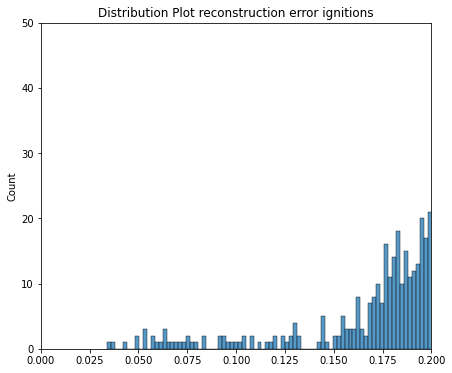

In [23]:
fig, ax = plt.subplots(figsize=(7,6))
ax.set_title('Distribution Plot reconstruction error ignitions')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlim(0,0.2)
plt.ylim(0,50)
sns.histplot(data=mae_vector_train, bins = 1000)

In [24]:
X_pred_test = vae_model.predict(X_test)
print('threshold', error_thresh,error_median)
#train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

mae_vector = get_error_term(X_pred_test, X_test, _rmse=False)
anomalies = (mae_vector > error_median)

np.count_nonzero(anomalies) / len(anomalies)
print('total non_ignitions',len(X_pred_test))
print('number of almost_ignitions', np.count_nonzero(anomalies==0))

#print('total y_test',len(y_test))
#print(np.count_nonzero(y_test))

threshold 1.3435935677236908 0.46031264017573686
total non_ignitions 1000000
number of almost_ignitions 377394


In [25]:
mae_vector

array([0.61129202, 0.59253649, 0.63000769, ..., 1.01249614, 0.50477576,
       0.55026865])

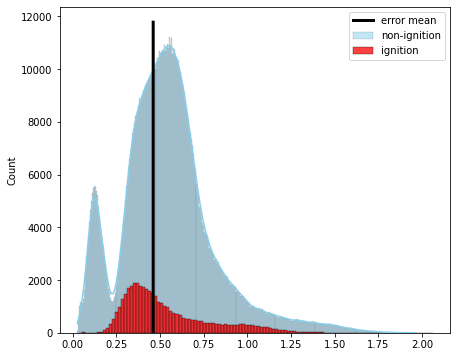

In [38]:
fig,ax1  = plt.subplots(figsize=(7,6))
sns.histplot(data=mae_vector, ax=ax1, color='skyblue', label='non-ignition', kde=True)
sns.histplot(data=mae_vector_train, ax=ax1, color='red', label='ignition')
xmin, xmax, ymin, ymax = plt.axis()
liney = np.arange(ymin, ymax, 0.01)
linex = np.ones(len(liney)) * error_median
sns.lineplot(x = linex, y= liney, color='black', ax=ax1, linewidth=3, estimator = None, label='error mean')
ax.set_title('Comparison reconstruction error ignition / non-ignition')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#plt.xlim(0,0.2)
#plt.ylim(0,8000)
plt.legend()
plt.show()

In [31]:
threshold_error = 0.175
near_ignitions = (mae_vector > threshold_error)

In [36]:
mae_vector

array([0.61129202, 0.59253649, 0.63000769, ..., 1.01249614, 0.50477576,
       0.55026865])

In [30]:
# second prediction with X_test vector to be used in PCA transformation
X_pred2 = vae_model.predict(X_test)
# PCA transformation to observe variance in 2 components

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_pred2)

/home/manero/DL/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


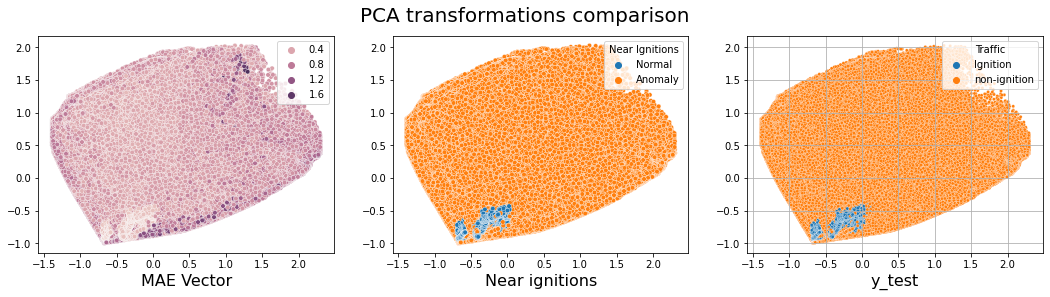

In [34]:
# Figure comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations explanation',size=20)

sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)

sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=near_ignitions, ax=ax2)
ax2.set_xlabel('Near ignitions', size = 16)
legend_labels2, _ = ax2.get_legend_handles_labels()
ax2.legend(legend_labels2, ['Ignition', 'non-ignition'], title='Near Ignitions')

sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=near_ignitions, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
legend_labels3, _ = ax3.get_legend_handles_labels()
ax3.legend(legend_labels3, ['Ignition', 'non-ignition'], title='Near ignitions')

plt.grid()
plt.show()

In [27]:
#===== program ends here. now create a new label and label non-ignition dataset with new class ===== #

In [28]:
import session_info
session_info.show(html=False)

-----
keras               2.12.0
matplotlib          3.5.0
numpy               1.22.4
pandas              1.5.3
seaborn             0.11.2
session_info        1.0.0
sklearn             1.2.1
tensorflow          2.12.0
-----
IPython             7.29.0
jupyter_client      8.2.0
jupyter_core        5.3.0
notebook            6.5.4
-----
Python 3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
Linux-5.19.0-45-generic-x86_64-with-glibc2.17
-----
Session information updated at 2023-06-24 23:40


### 